# XGBoost Notebook

This Notebook trains an XGBoost model, predicts the player's points for the upcoming gameweeks, and saves these predictions.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
from tabulate import tabulate
import requests
import pickle

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

### Load data

In [2]:
# Load the saved JSON data from the file
with open("data/overall_data.json", "r") as f:
    data = json.load(f)
players = data['elements']

# Create player_overall_stats
player_overall_stats = {}
for player in players:
    player_id = str(player['id'])
    player_overall_stats[player_id] = player

In [3]:
# Load training data
X = np.load('data/xgboost/X_train.npy')
y = np.load('data/xgboost/y_train.npy')
played = np.load('data/xgboost/played_train.npy') # Optional: Used to remove data where a player did not play

print("Training data (X):", X.shape)
print("Target values (y):", y.shape)
print("Played values (y):", played.shape)

Training data (X): (99749, 195)
Target values (y): (99749,)
Played values (y): (99749,)


In [4]:
# Load test data
with open('data/xgboost/X_test.pkl', 'rb') as f:
    X_test_games = pickle.load(f)

with open('data/xgboost/xP_test.pkl', 'rb') as f:
    eP_games = pickle.load(f)

with open('data/xgboost/names_test.pkl', 'rb') as f:
    player_names_games = pickle.load(f)
    
with open('data/xgboost/id_dict.pkl', 'rb') as f:
    id_dict = pickle.load(f)
    
with open('data/xgboost/name_to_id.pkl', 'rb') as f:
    name_to_id = pickle.load(f)

### Train model

In [5]:
# Split the data into training and testing sets
y_clipped = np.clip(y, 0, 12)
X_train, X_val, y_train, y_val, played_train, played_val = train_test_split(X,y_clipped,played,test_size=0.2,random_state=42)

# Normalize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

# Put more weight on high-scoring players
weights = np.where(y_train > 2, 1.5, 1.0)

# Train model
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=50)
model.fit(X_train, y_train, sample_weight=weights)

# Predict and evaluate
predictions = model.predict(X_val)
mse = mean_squared_error(y_val, predictions)
print(f'Mean Squared Error: {mse:.2f}')

Mean Squared Error: 4.65


### Show results - Training set

Mean Squared Error: 3.60


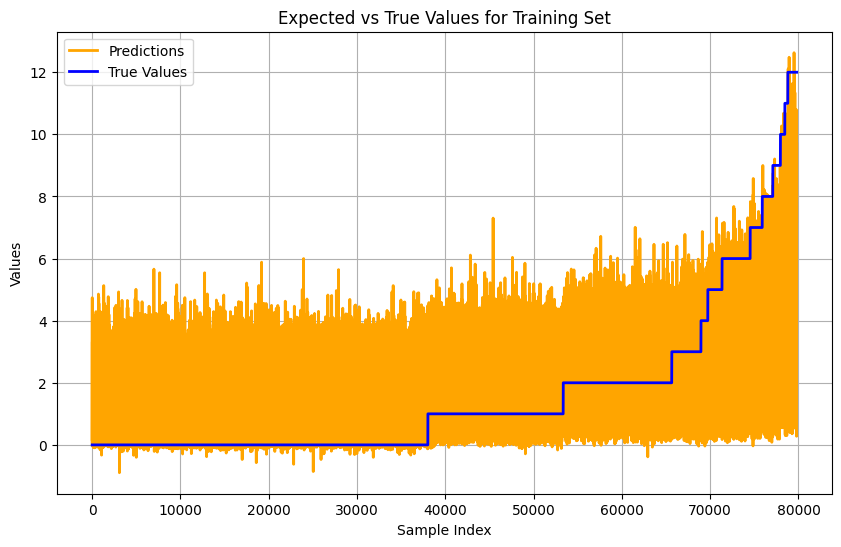

In [6]:
# Predict and evaluate
predictions = model.predict(X_train)
mse = mean_squared_error(y_train, predictions)
print(f'Mean Squared Error: {mse:.2f}')

# Sort values for a better line plot
sorted_indices = np.argsort(y_train)
sorted_y_train = y_train[sorted_indices]
sorted_predictions = predictions[sorted_indices]

# Plot expected values and true values
plt.figure(figsize=(10, 6))
plt.plot(sorted_predictions, label='Predictions', color='orange', linewidth=2)
plt.plot(sorted_y_train, label='True Values', color='blue', linewidth=2)
plt.xlabel('Sample Index')
plt.ylabel('Values')
plt.title('Expected vs True Values for Training Set')
plt.legend()
plt.grid(True)
plt.show()

### Show results - Validation set

Mean Squared Error: 4.65


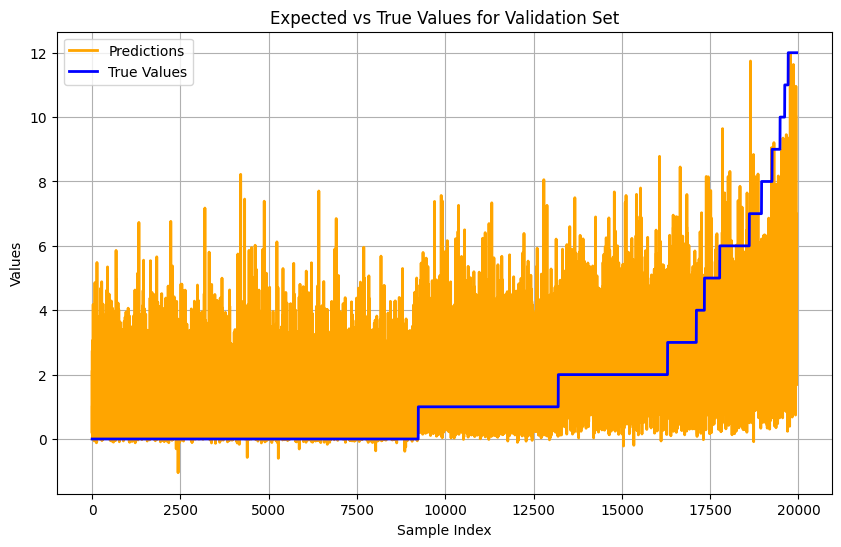

In [7]:
# Predict and evaluate
predictions = model.predict(X_val)
mse = mean_squared_error(y_val, predictions)
print(f'Mean Squared Error: {mse:.2f}')

# Sort values for a better line plot
sorted_indices = np.argsort(y_val)
sorted_y_val = y_val[sorted_indices]
sorted_predictions = predictions[sorted_indices]

# Plot expected values and true values
plt.figure(figsize=(10, 6))
plt.plot(sorted_predictions, label='Predictions', color='orange', linewidth=2)
plt.plot(sorted_y_val, label='True Values', color='blue', linewidth=2)
plt.xlabel('Sample Index')
plt.ylabel('Values')
plt.title('Expected vs True Values for Validation Set')
plt.legend()
plt.grid(True)
plt.show()

### Predictions - next gameweek

Mean Squared Error: 1.89


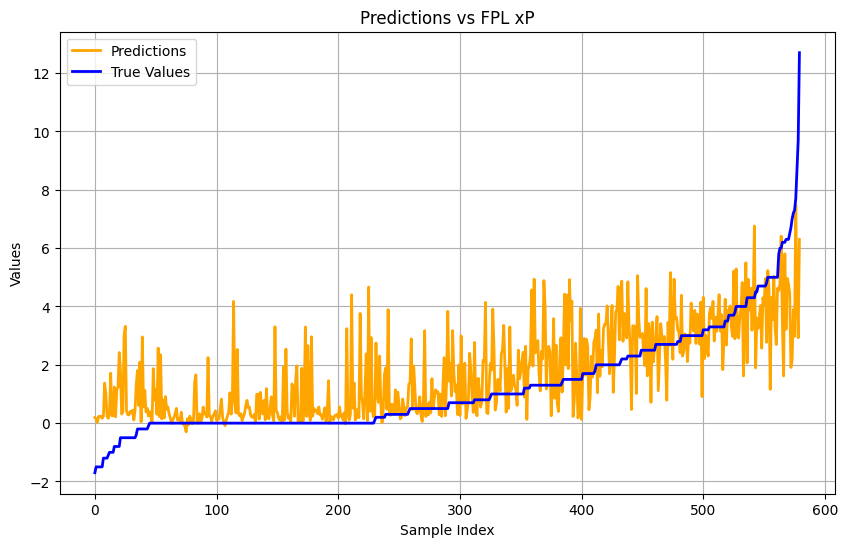

In [8]:
# Get test data
X_test = X_test_games[0]
X_test = scaler.transform(X_test)
y_test = eP_games[0]
player_ids_test = player_names_games[0]

# Make predictions on the test data
predictions = model.predict(X_test)
mse = mean_squared_error(eP_games[0], predictions)
print(f'Mean Squared Error: {mse:.2f}')

# Sort values for a better line plot
sorted_indices = np.argsort(eP_games[0])
sorted_ep = eP_games[0][sorted_indices]
sorted_predictions = predictions[sorted_indices]

# Plot expected values and true values
plt.figure(figsize=(10, 6))
plt.plot(sorted_predictions, label='Predictions', color='orange', linewidth=2)
plt.plot(sorted_ep, label='True Values', color='blue', linewidth=2)
plt.xlabel('Sample Index')
plt.ylabel('Values')
plt.title('Predictions vs FPL xP')
plt.legend()
plt.grid(True)
plt.show()

In [22]:
# Sum predicted scores for next 5 gameweeks
predictions_5 = []
for i in range(5):
    X_test = X_test_games[i]
    X_test = scaler.transform(X_test)
    predictions_5.append(model.predict(X_test))
predictions_sum = np.sum(np.array(predictions_5), axis=0)

# Highest predictions (top 10)
top_10_indices = np.argsort(predictions)[-10:][::-1]

# Prepare data for top 10 predictions table
top_10_data = []
for num, i in enumerate(top_10_indices):
    name = player_overall_stats[name_to_id[player_ids_test[i]]]['web_name']
    play_chance = player_overall_stats[name_to_id[player_ids_test[i]]]['chance_of_playing_next_round']
    top_10_data.append([num + 1, name, f'{predictions[i]:.2f}', f'{y_test[i]:.2f}', 
                        f'{predictions_sum[i]:.2f}', f'{play_chance}'])

# Print the top 10 predictions as a table
print("Top 10 Highest Predicted Players:")
print(tabulate(top_10_data, headers=["Rank", "Player", "Predicted Score", "FPL xP", 
                                     "Sum next 5 games", "Chance of playing"], tablefmt="pretty"))

# Initialize an empty dictionary to store top 5 players for each position
top_players_by_position = {'GK': [], 'DEF': [], 'MID': [], 'FWD': []}
position_mapping = {1: 'GK', 2: 'DEF', 3: 'MID', 4: 'FWD'}

# Iterate through each player, filtering by position and appending the data
for i in range(len(predictions)):
    player_id = name_to_id[player_ids_test[i]]
    pp = player_overall_stats[player_id]
    position = pp['element_type']
    play_chance = player_overall_stats[name_to_id[player_ids_test[i]]]['chance_of_playing_next_round']
    
    # Store the player data as a tuple and append to corresponding position
    player_data = (predictions[i], y_test[i], pp['web_name'], predictions_sum[i], play_chance)
    top_players_by_position[position_mapping[position]].append(player_data)

# Sort and extract top 5 players for each position
for position, players in top_players_by_position.items():
    # Sort by predicted score in descending order
    players_sorted = sorted(players, key=lambda x: x[0], reverse=True)
    
    # Get top 5 players
    top_5 = players_sorted[:5]
    
    print(f"\nTop 5 for {position}:")
    position_data = []
    for num, player in enumerate(top_5, 1):
        predicted_score, actual_score, web_name, sum5, play_chance = player
        position_data.append([num, web_name, f'{predicted_score:.2f}', f'{actual_score:.2f}', f'{sum5:.2f}',
                             f'{play_chance}'])
    
    # Print position-specific table
    print(tabulate(position_data, headers=["Rank", "Player", "Predicted Score", "FPL xP",
                                           "Sum next 5 games", "Chance of playing"], tablefmt="pretty"))

Top 10 Highest Predicted Players:
+------+------------+-----------------+--------+------------------+-------------------+
| Rank |   Player   | Predicted Score | FPL xP | Sum next 5 games | Chance of playing |
+------+------------+-----------------+--------+------------------+-------------------+
|  1   | Evanilson  |      7.47       |  7.70  |      34.71       |       None        |
|  2   |  Haaland   |      6.76       |  4.30  |      29.06       |        100        |
|  3   |   Delap    |      6.41       |  6.00  |      33.14       |       None        |
|  4   |  M.Salah   |      6.30       | 12.70  |      34.18       |       None        |
|  5   |   Wissa    |      5.81       |  6.20  |      31.87       |        75         |
|  6   | Luis Díaz  |      5.50       |  4.00  |      24.73       |       None        |
|  7   |    Saka    |      5.29       |  4.00  |      24.10       |        75         |
|  8   | Joelinton  |      5.23       |  5.00  |      25.09       |       None        

In [23]:
# Highest predictions (top 10)
top_10_indices = np.argsort(predictions_sum.flatten())[-10:][::-1]

# Prepare data for top 10 predictions table
top_10_data = []
for num, i in enumerate(top_10_indices):
    name = player_overall_stats[name_to_id[player_ids_test[i]]]['web_name']
    play_chance = player_overall_stats[name_to_id[player_ids_test[i]]]['chance_of_playing_next_round']
    top_10_data.append([num + 1, name, f'{predictions[i]:.2f}', f'{y_test[i]:.2f}', 
                        f'{predictions_sum[i]:.2f}', f'{play_chance}'])

# Print the top 10 predictions as a table
print("Top 10 Highest Predicted Players, sorted by sum of next 5 games:")
print(tabulate(top_10_data, headers=["Rank", "Player", "Predicted Score", "FPL xP", 
                                     "Sum next 5 games", "Chance of playing"], tablefmt="pretty"))

# Initialize an empty dictionary to store top 5 players for each position
top_players_by_position = {'GK': [], 'DEF': [], 'MID': [], 'FWD': []}
position_mapping = {1: 'GK', 2: 'DEF', 3: 'MID', 4: 'FWD'}

# Iterate through each player, filtering by position and appending the data
for i in range(len(predictions)):
    player_id = name_to_id[player_ids_test[i]]
    pp = player_overall_stats[player_id]
    position = pp['element_type']
    play_chance = player_overall_stats[name_to_id[player_ids_test[i]]]['chance_of_playing_next_round']
    
    # Store the player data as a tuple and append to corresponding position
    player_data = (predictions[i], y_test[i], pp['web_name'], predictions_sum[i], play_chance)
    top_players_by_position[position_mapping[position]].append(player_data)

# Sort and extract top 5 players for each position
for position, players in top_players_by_position.items():
    # Sort by predicted score in descending order
    players_sorted = sorted(players, key=lambda x: x[3], reverse=True)
    
    # Get top 5 players
    top_5 = players_sorted[:5]
    
    print(f"\nTop 5 for {position}:")
    position_data = []
    for num, player in enumerate(top_5, 1):
        predicted_score, actual_score, web_name, sum5, play_chance = player
        position_data.append([num, web_name, f'{predicted_score:.2f}', f'{actual_score:.2f}', f'{sum5:.2f}',
                             f'{play_chance}'])
    
    # Print position-specific table
    print(tabulate(position_data, headers=["Rank", "Player", "Predicted Score", "FPL xP",
                                           "Sum next 5 games", "Chance of playing"], tablefmt="pretty"))

Top 10 Highest Predicted Players, sorted by sum of next 5 games:
+------+------------+-----------------+--------+------------------+-------------------+
| Rank |   Player   | Predicted Score | FPL xP | Sum next 5 games | Chance of playing |
+------+------------+-----------------+--------+------------------+-------------------+
|  1   | Evanilson  |      7.47       |  7.70  |      34.71       |       None        |
|  2   |  M.Salah   |      6.30       | 12.70  |      34.18       |       None        |
|  3   |   Delap    |      6.41       |  6.00  |      33.14       |       None        |
|  4   |   Wissa    |      5.81       |  6.20  |      31.87       |        75         |
|  5   | João Pedro |      5.21       |  3.70  |      30.31       |        100        |
|  6   |  Haaland   |      6.76       |  4.30  |      29.06       |        100        |
|  7   |    Neto    |      4.96       |  4.70  |      28.41       |       None        |
|  8   |  Szmodics  |      4.96       |  6.30  |      2

### Load my team data

In [86]:
user_id = 10581845
url = f'https://fantasy.premierleague.com/api/entry/{user_id}/event/{11}/picks/'

response = requests.get(url)
data = response.json()

In [87]:
# Prepare a mapping of positions
position_mapping = {1: 'Goalkeeper', 2: 'Defender', 3: 'Midfielder', 4: 'Forward'}

# Prepare data for each position
grouped_data = {'Goalkeeper': [], 'Defender': [], 'Midfielder': [], 'Forward': []}

# Populate grouped data based on position
for player in data['picks']:
    player_name = id_dict[str(player["element"])]
    prediction = predictions[player_ids_test.index(player_name)]
    sum5 = predictions_sum[player_ids_test.index(player_name)]
    fpl_xp = y_test[player_ids_test.index(player_name)]
    player_position = position_mapping[player_overall_stats[str(player['element'])]['element_type']]
    grouped_data[player_position].append([player_name, f"{prediction:.2f}", f'{fpl_xp:.2f}', f"{sum5:.2f}"])

# Display each group in separate tables
for position, players in grouped_data.items():
    print(f"\nPosition: {position}")
    print(tabulate(players, headers=['Player Name', 'Predicted Score', "FPL xP", 'Sum next 5 games'], tablefmt="pretty"))


Position: Goalkeeper
+-------------------+-----------------+--------+------------------+
|    Player Name    | Predicted Score | FPL xP | Sum next 5 games |
+-------------------+-----------------+--------+------------------+
| David Raya Martin |      5.16       |  2.70  |      25.17       |
| Łukasz Fabiański  |      3.24       |  4.70  |      15.90       |
+-------------------+-----------------+--------+------------------+

Position: Defender
+------------------------------+-----------------+--------+------------------+
|         Player Name          | Predicted Score | FPL xP | Sum next 5 games |
+------------------------------+-----------------+--------+------------------+
| Gabriel dos Santos Magalhães |      4.94       |  2.70  |      23.86       |
|       Rayan Aït-Nouri        |      4.25       |  3.50  |      20.80       |
|        Ethan Pinnock         |      3.30       |  1.00  |      17.74       |
|         Jonny Evans          |      1.14       |  0.30  |       5.45      

### Optimization problem

**Constraints**

Squad constraints:
- 2 GK, 5 DEF, 5 MID, 3 FWD in squad (15 players total)
- Max 3 players from each team in squad

Start 11 constraints:
- Exactly 1 GK
- At least 3 DEF
- At least 2 MID
- At least 1 FWD
- Exactly 11 players total

Transfer constraints:
- Must not exceed total bank balance
- Cost of extra transfers

**Optimization**

- Optimize points scored by start 11
- Include points for following gameweeks
- Prioritise not to make transfers if little/no points gain (to save transfers for next rounds)

In [34]:
import pulp

In [68]:
squad = []
for player in data['picks']:
    squad.append(str(player['element']))

In [69]:
position_mapping = {1: 'GK', 2: 'DEF', 3: 'MID', 4: 'FWD'}
players = []

for key, value in player_overall_stats.items():
    
    # Skip if no prediction for player
    if not id_dict[key] in player_ids_test:
        continue
        
    # Add player stats
    p = {"id": key,
         "position": position_mapping[value['element_type']],
         "team": value['team'], 
         "cost": value['now_cost']}
    
    # Add predicted points
    predicted_index = player_ids_test.index(id_dict[key])
    p["predicted_points"] = predictions[predicted_index]
    
    # Add in squad or not
    if key in squad:
        p["in_current_squad"] = 1
    else:
        p["in_current_squad"] = 0
        
    players.append(p)

In [81]:
# data

In [91]:
# Parameters
bank_balance = data['entry_history']['bank']  # Money left in bank
free_transfers = 2  # Number of free transfers available - find out where to use API for this

# Create problem
prob = pulp.LpProblem("FPL_Team_Optimization", pulp.LpMaximize)

# Decision variables
x = {p['id']: pulp.LpVariable(f"x_{p['id']}", cat="Binary") for p in players}  # Squad selection
y = {p['id']: pulp.LpVariable(f"y_{p['id']}", cat="Binary") for p in players}  # Starting 11 selection

# Objective function: Maximize expected points of the starting 11
prob += pulp.lpSum(y[p['id']] * p['predicted_points'] for p in players)

# Constraints
# Squad size and composition
prob += pulp.lpSum(x[p['id']] for p in players) == 15
prob += pulp.lpSum(x[p['id']] for p in players if p['position'] == "GK") == 2
prob += pulp.lpSum(x[p['id']] for p in players if p['position'] == "DEF") == 5
prob += pulp.lpSum(x[p['id']] for p in players if p['position'] == "MID") == 5
prob += pulp.lpSum(x[p['id']] for p in players if p['position'] == "FWD") == 3

# Max 3 players per team
teams = set(p['team'] for p in players)
for team in teams:
    prob += pulp.lpSum(x[p['id']] for p in players if p['team'] == team) <= 3

# Starting 11 composition
prob += pulp.lpSum(y[p['id']] for p in players) == 11
prob += pulp.lpSum(y[p['id']] for p in players if p['position'] == "GK") == 1
prob += pulp.lpSum(y[p['id']] for p in players if p['position'] == "DEF") >= 3
prob += pulp.lpSum(y[p['id']] for p in players if p['position'] == "MID") >= 2
prob += pulp.lpSum(y[p['id']] for p in players if p['position'] == "FWD") >= 1

# Starting 11 must be in squad
for p in players:
    prob += y[p['id']] <= x[p['id']]

# Transfer cost and budget
total_cost = pulp.lpSum(p['cost'] * (x[p['id']] - p['in_current_squad']) for p in players)
extra_transfers = pulp.lpSum(x[p['id']] - p['in_current_squad'] for p in players) - free_transfers
prob += total_cost <= bank_balance
# (Optional) Penalize extra transfers
prob += extra_transfers <= 0  # Or add penalties to objective

# Solve
prob.solve()

# Extract results
selected_squad = [p for p in players if pulp.value(x[p['id']]) > 0.5]
starting_11 = [p for p in players if pulp.value(y[p['id']]) > 0.5]

print("Selected Squad:", selected_squad)
print("Starting 11:", starting_11)


TypeError: list indices must be integers or slices, not str

In [ ]:
# Get unique values and their counts
unique_values, counts = np.unique(y, return_counts=True)

# Combine the results into a dictionary for better readability
value_counts = dict(zip(unique_values, counts))

value_counts